# Response of Tropical Cyclones to Volcanic Eruptions

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd

import geoxarray
from geoplots import mapplot, yticks2lat

from itertools import product
from cftime import DatetimeJulian
import xarray as xr

<IPython.core.display.Javascript object>


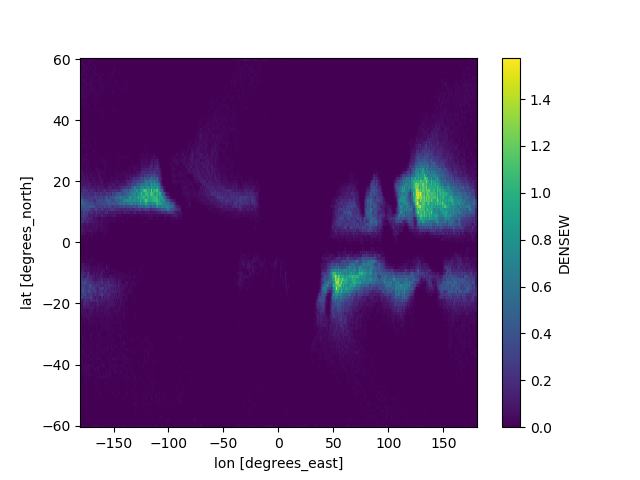

In [2]:
# data
new_names = dict(XAX='lon', YAX='lat', YRT='time')
data_name = 'DENSEW'
ncfile = '/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_CTL1860_noleap/NETCDF_TRACKS/dens.nc'
da = xr.open_dataset(ncfile).rename(new_names)[data_name]
ref200 = da.sel(time=slice(11,211)).mean('time')
ref200.plot()

In [3]:
ncfiles = dict(stmaria='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_STMARIA_ens_noleap/NETCDF_TRACKS/dens.nc',
              agung='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_AGUNG_ens_noleap/NETCDF_TRACKS/dens.nc',
              pinatubo='/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_PINATUBO_ens_noleap/NETCDF_TRACKS/dens.nc')

<IPython.core.display.Javascript object>


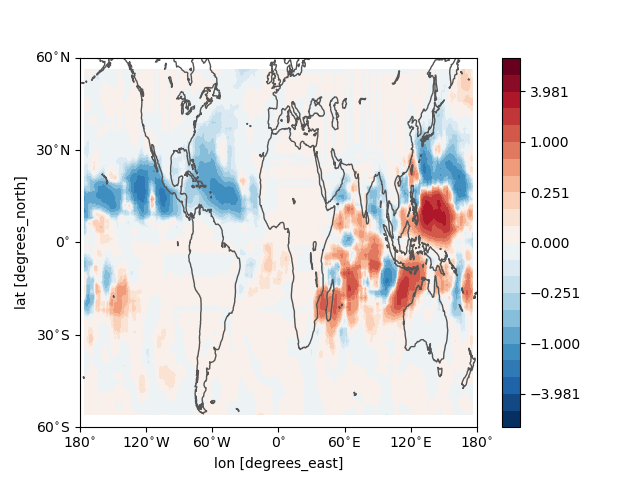

In [4]:
# levels = list(np.arange(-10, -4, 2)) \
#     + list(np.arange(-4, -1, 1)) \
#     + list(np.arange(-1, 1, 0.1)) \
#     + list(np.arange(1, 4, 1)) \
#     + list(np.arange(4, 10.1, 2))
# levels = np.arange(-2, 2.1, 0.2)
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
da = xr.open_dataset(ncfiles['stmaria'])[data_name].rename(new_names)/30.0
da.isel(time=slice(0,3)).mean('time').pipe(lambda x: x-ref200).pipe(lambda x: x*100/4) \
    .rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean().plot.contourf(levels=levels)
mapplot()

<IPython.core.display.Javascript object>


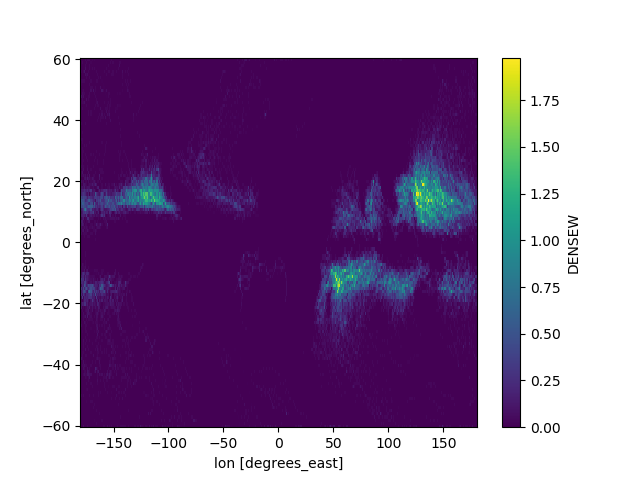

In [5]:
# data: ctl
new_names = dict(XAX='lon', YAX='lat', YRT='time')
data_name = 'DENSEW'
ncfile = '/tigress/gvecchi/ANALYSIS/FLOR/TCs_LUCAS/TRAJ_CTL1860_noleap/NETCDF_TRACKS/dens.nc'
da = xr.open_dataset(ncfile).rename(new_names)[data_name]
ens = range(1,31) #range(1, 31)
das = []
for en in ens:
    tmp = da.sel(time=slice(10+en, 10+en+4))
    tmp['time'] = range(1,6)
    das.append(tmp)
ref = xr.concat(das, dim=pd.Index(ens, name='en'))
ref.sel(time=slice(1,3)).mean(['en', 'time']).plot()

In [6]:
# data: volc exps
das = dict()
for volc_name in ['stmaria', 'agung', 'pinatubo']:
    da = xr.open_dataset(ncfiles[volc_name])[data_name].rename(new_names)/30
    das[volc_name] = da

## Figure

<IPython.core.display.Javascript object>


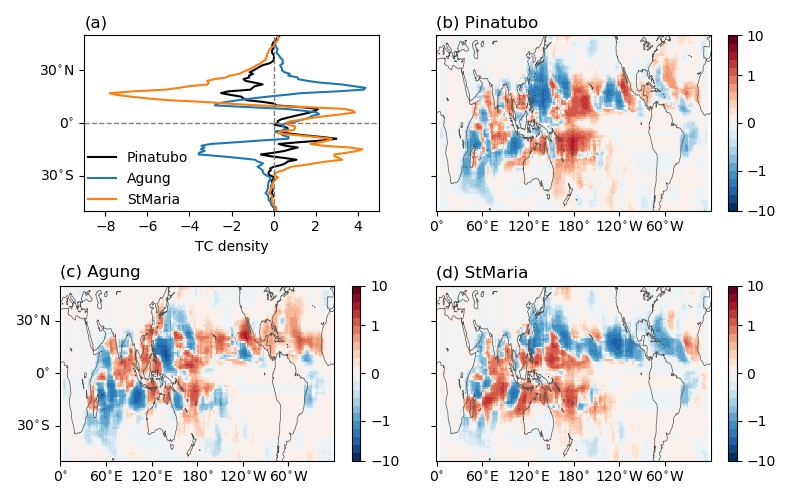

In [22]:
# fig
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
ax.set_aspect(1/12)
# plt.sca(ax)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='k')
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='C0')
volc_name, tag = 'stmaria', 'StMaria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5, color='C1')
ax.legend(loc='lower left', bbox_to_anchor=(-.03,-.05))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
# ax.grid('on')
ax.set_title('(a)', loc='left')
ax.set_xlabel('TC density')
ax.set_xlim(-9,5)
# yticks2lat(np.arange(-45,46,15))
ax.axhline(0, color='gray', lw=1, ls='--')
ax.axvline(0, color='gray', lw=1, ls='--')

ax = axes[0, 1]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Pinatubo', loc='left')

ax = axes[1, 0]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Agung', loc='left')



ax = axes[1, 1]
plt.sca(ax)
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=10, center=True).sum() \
    .rolling(lat=10, center=True).sum() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
ax.set_yticks(np.arange(-45,46,15))
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(d) StMaria', loc='left')
# yticks2lat(np.arange(-45,46,15))



plt.tight_layout()

figname = 'figs/fig_tc.pdf'
plt.savefig(figname)

<IPython.core.display.Javascript object>


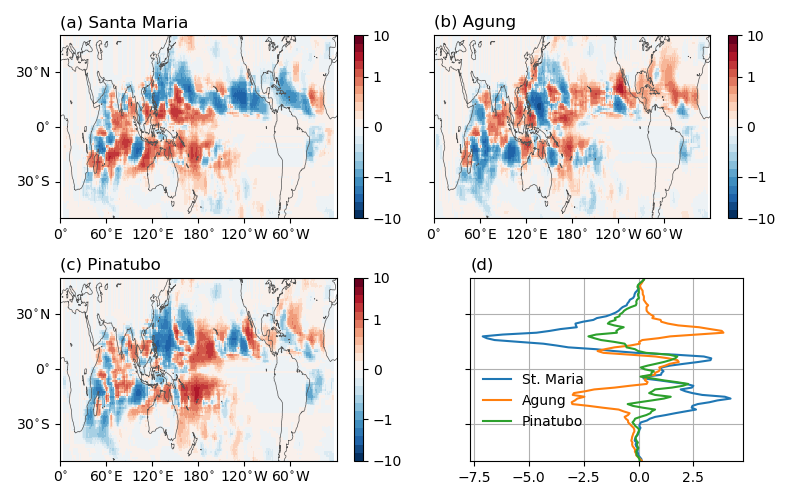

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [36]:
# fig: 9x9 grids
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(a) Santa Maria', loc='left')

ax = axes[0, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Agung', loc='left')

ax = axes[1, 0]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Pinatubo', loc='left')

ax = axes[1, 1]
ax.set_aspect(1/12)
plt.sca(ax)
volc_name, tag = 'stmaria', 'St. Maria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref.isel(time=slice(0, n_years)).mean(['en', 'time'])) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag, lw=1.5)
plt.legend(loc='upper left', bbox_to_anchor=(0,.55))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
plt.grid('on')
plt.title('(d)', loc='left')


plt.tight_layout()

figname = 'figs/fig_tc_9x9.pdf'
plt.savefig(figname)

## 200 CTL years

<IPython.core.display.Javascript object>


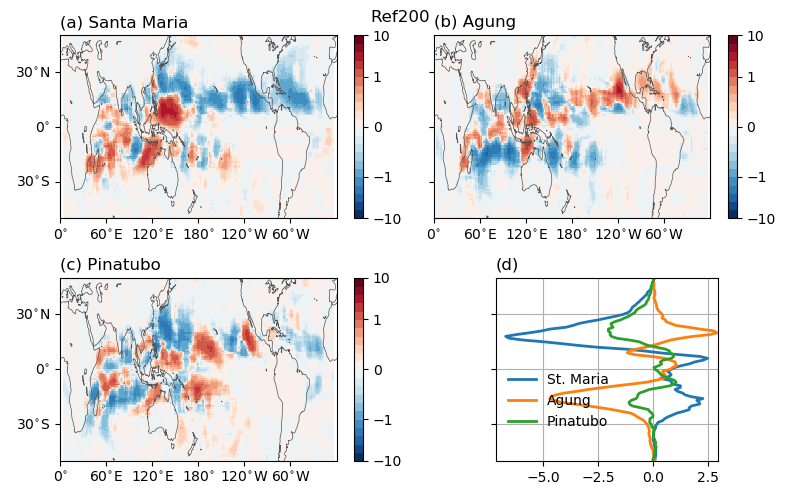

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [18]:
# fig: ref200
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharey=True)
n_years = 3
lv = 10**np.arange(-1, 1.1, .2)
levels = list(-lv[-1::-1]) + [0,] + list(lv)
coastline_width = .5
cbar_ticks = [-10, -1, 0, 1, 10]

ax = axes[0, 0]
volc_name = 'stmaria'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(a) Santa Maria', loc='left')

ax = axes[0, 1]
volc_name = 'agung'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(b) Agung', loc='left')

ax = axes[1, 0]
volc_name = 'pinatubo'
da = das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200).pipe(lambda x: x*100/4)
da = xr.concat([da.sel(lon=slice(0, 180)), da.sel(lon=slice(-179, 0))], dim='lon')
da['lon'] = np.arange(0, 361)
da.rolling(lon=9, center=True).mean() \
    .rolling(lat=9, center=True).mean() \
    .plot(ax=ax, levels=levels, cbar_kwargs={'ticks': cbar_ticks}, rasterized=True)
mapplot(ax=ax, lon=da.lon, lat=(-50, 50), linewidth=coastline_width)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('(c) Pinatubo', loc='left')

ax = axes[1, 1]
ax.set_aspect(1/12)
plt.sca(ax)
volc_name, tag = 'stmaria', 'St. Maria'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
volc_name, tag = 'agung', 'Agung'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
volc_name, tag = 'pinatubo', 'Pinatubo'
das[volc_name].isel(time=slice(0, n_years)).mean('time') \
    .pipe(lambda x: x - ref200) \
    .sum('lon') \
    .rolling(lat=11, center=True).mean() \
    .plot(ax=ax, y='lat', label=tag)
plt.legend(loc='upper left', bbox_to_anchor=(0,.55))
ax.set_ylim(-50, 50)
ax.set_ylabel('')
plt.grid('on')
plt.title('(d)', loc='left')

plt.suptitle('Ref200')
plt.tight_layout()

figname = 'figs/fig_tc_ref200.pdf'
plt.savefig(figname)

In [ ]:
ax.grid